En este trabajo buscaré generar el mejor modelo para ganar la competencia de la Fundación Sadosky sobre la detencción de transacciones apócrifas en Despegar: https://metadata.fundacionsadosky.org.ar/competition/3/

In [1]:
# data analysis and wrangling
import pandas as pd
import numpy as np
import random as rnd

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
#matplotlib inline

# machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
import seaborn as sns
import matplotlib.pyplot as plt

In [302]:
pd.set_option('display.max_columns', 500)
train_df = pd.read_csv('train.csv')
train_df.tail()

,id,AfsScore,DeviceMatch,FactorCodes,FirstEncounter,IcAddress,IcInternet,IcSuspicious,IcVelocity,Icidentity,IpRoutingMethod,ReasonCode,TimeOnPage,billingCountryCode,cancelled,cardCountryCode,card_bin_1,card_bin_30,card_bin_60,card_bin_90,caseDate,case_minutes_distance,cases_count,channel,count_different_cards,count_different_installments,countryCode,countryFrom,countryTo,distance_to_arrival,distance_to_departure,domain_proc,eaAdviceId,eaFirstVerificationDate,eaReasonId,eaRiskBandId,eaScore,eaStatusId,eaUniqueHits,eulerAllAvgSessionTimeSecs,eulerAllBuyCount,eulerAllSearchCount,eulerBadge,eulerBuyPaxDist,eulerBuyTripType,eulerFriendsIds,eulerMobileAppInstalled,eulerSearchUrgency,eulerSocialNetwork,eulerall_searchPaxDistCount,eulerlastSessionTimeSecs,fraud,friendly,hours_since_first_verification,iataFrom,iataTo,ip_city,issued,julixBrowserLanguage,julixHasNegativeHit,julixHasSuspectHit,julixOs,julixPolicyScore,julixPositiveUserLevel,julixReasonCode,julixTrueIpCity,julixTrueIpRegion,julixTrueIpScore,lagTimeHours,many_holders_for_card,many_names_for_document,online_airport_state,online_billing_address_state,online_cep_number_bond,online_city_bond,online_ddd,online_ddd_bond,online_death,online_email,online_family_bond,online_ip_state,online_name,online_phone,online_queries,online_state_bond,paymentsCardType,paymentsInstallments,same_field_features,speed_to_departure,totalUsdAmount,triangulation_height,triangulation_height_speed,trip_distance
40303,60664,41.0,1,1,0,2,1,16,15,1,1,100.0,316420.0,BR,0,BR,1.0,1.0,1.0,1.0,2017-03-24T16:07:30Z,NaN,1.0,site,NaN,NaN,BR,BR,BR,983.0,32.7,NaN,3.0,2015-06-15T07:46:19Z,11.0,1.0,50.0,2.0,1.0,801.0,2.0,6.0,BUYER,1|0|0,ROUNDTRIP,75539b27-e52e-4dcb-939b-27e52e6dcb53|953d140d-...,0.0,ACTIVE,DESPEGAR,6.0,801.0,0.0,0,15560.0,CNF,SSA,BHZ,1,"pt-BR,pt;q",0.0,0.0,Windows,-10.0,0.0,Flash_Disabled,governador valadares,minas gerais,3.0,498,NaN,NaN,0,1,1,2,0,2,1,1,1,1,1,1,8,2,CA,3,"{u'same_phone': {}, u'same_ip': {}, u'same_doc...",0.1,203.0,22.89,0.1,959.4
40304,60665,34.0,0,13,0,0,3,0,1,1,2,480.0,NaN,NaN,1,BR,1.0,1.0,1.0,1.0,2017-02-15T22:40:04Z,NaN,1.0,iphone-app,NaN,NaN,BR,BR,BR,928.1,742.8,0.0592,3.0,2016-03-26T07:00:00Z,14.0,2.0,223.0,2.0,1.0,446.0,1.0,2.0,BUYER,2|2|0,one_way,NaN,1.0,INACTIVE,DESPEGAR,1.0,446.0,1.0,0,7839.0,CGB,GIG,GYN,0,pt-br,0.0,0.0,iOS,-65.0,0.0,3 IPs Same Device per Day,sao paulo,sao paulo,0.0,109,NaN,NaN,1,0,0,0,0,0,0,0,0,0,0,2,4,0,VI,3,"{u'same_phone': {u'issued_counter': 3, u'issue...",6.8,671.0,285.47,2.6,1568.9
40305,60666,0.0,2,1,0,0,0,6,2,1,1,100.0,1015192.0,NaN,0,BR,1.0,1.0,1.0,1.0,2017-04-10T19:21:08Z,NaN,1.0,site,NaN,NaN,BR,BR,PL,8.8,8949.1,NaN,3.0,2014-04-18T07:00:00Z,14.0,2.0,125.0,2.0,1.0,1169.0,1.0,2.0,BUYER,2|0|0,ROUNDTRIP,NaN,0.0,URGENT,NaN,1.0,1169.0,0.0,0,26124.0,AJU,WAW,SUCIR,1,en-us,0.0,0.0,OS X,-20.0,0.0,Flash_Disabled,warszawa,mazowieckie,0.0,3036,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,2,0,AX,10,"{u'same_phone': {u'issued_max_days': 393, u'is...",3.0,2655.0,3.36,0.0,8940.9
40306,60667,36.0,1,1,296,2,1,6,12,12,2,100.0,346065.0,BR,0,BR,1.0,1.0,1.0,1.0,2017-06-22T19:49:35Z,6.0,2.0,site,2.0,1.0,BR,BR,BR,190.6,32.2,NaN,3.0,2009-10-13T14:00:00Z,14.0,1.0,82.0,2.0,1.0,2708.0,2.0,8.0,BUYER,1|0|0,ROUNDTRIP,c5f21127-9f62-41cb-b211-279f6241cb87|ac288133-...,1.0,ACTIVE,DESPEGAR,6.0,4804.0,0.0,0,67421.0,MCZ,REC,NNQWN,1,"pt-BR,pt;q",0.0,0.0,Windows,-10.0,0.0,Flash_Disabled,rio de janeiro,rio de janeiro,9.0,326,NaN,NaN,0,5,2,2,0,2,1,3,2,0,1,1,0,2,VI,6,"{u'same_phone': {u'issued_counter': 35, u'issu...",0.1,187.0,31.59,0.1,181.8
40307,60670,0.0,2,1,0,2,5,6,2,1,1,100.0,630767.0,BR,0,BR,1.0,1.0,1.0,1.0,2017-04-06T17:03:00Z,NaN,1.0,site,NaN,NaN,BR,BR,BR,20.8,1705.8,0.0000,3.0,2012-01-04T07:00:00Z,14.0,1.0,93.0,2.0,1.0,1038.0,1.0,7.0,CHECKER,1|0|0,ONEWAY,NaN,0.0,INACTIVE,NaN,7.0,1038.0,0.0,0,46066.0,PNZ,GRU,SAO,1,"pt-BR,pt;q",0.0,0.0,Windows,0.0,0.0,NaN,sao paulo,sao paulo,0.0,710,NaN,NaN,0,1,1,1,0,1,1,1,1,1,1,1,1,1,VI,6,"{u'same_phone': {}, u'same_ip': {}, u'same_doc...",2.4,104.0,8.78,0.0,

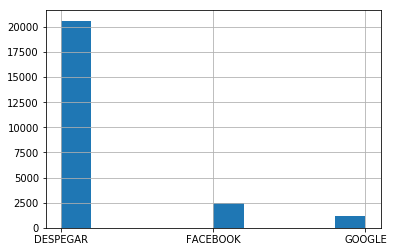

In [3]:
train_df.eulerSocialNetwork.hist()


In [303]:
#Relleno las billingcountrycode faltantes con el country code de la tarjeta
#train_df['billingCountryCode'].fillna(train_df['cardCountryCode'], inplace=True)
#agrego la red social "desconocida"
train_df['eulerSocialNetwork'].fillna(0, inplace=True)

#train_df['domain_proc'].fillna(train_df['domain_proc'].dropna().median(), inplace=True)

##casteo las fechas
train_df['hours_since_first_verification'] = (pd.to_datetime(train_df['caseDate']) - pd.to_datetime(train_df['eaFirstVerificationDate'])).astype('timedelta64[h]')
train_df['caseDate'] = pd.to_datetime(train_df['caseDate']).dt.hour
#calculo los valores faltantes de esta columna
train_df['eaFirstVerificationDate'] = pd.to_datetime(train_df['eaFirstVerificationDate']).values.astype(np.int64) // 10 ** 9

In [78]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40308 entries, 0 to 40307
Data columns (total 93 columns):
id                                40308 non-null int64
AfsScore                          40226 non-null float64
DeviceMatch                       40308 non-null int64
FactorCodes                       40308 non-null int64
FirstEncounter                    40308 non-null int64
IcAddress                         40308 non-null int64
IcInternet                        40308 non-null int64
IcSuspicious                      40308 non-null int64
IcVelocity                        40308 non-null int64
Icidentity                        40308 non-null int64
IpRoutingMethod                   40308 non-null int64
ReasonCode                        40268 non-null float64
TimeOnPage                        30532 non-null float64
billingCountryCode                31012 non-null object
cancelled                         40308 non-null int64
cardCountryCode                   40278 non-null object
car

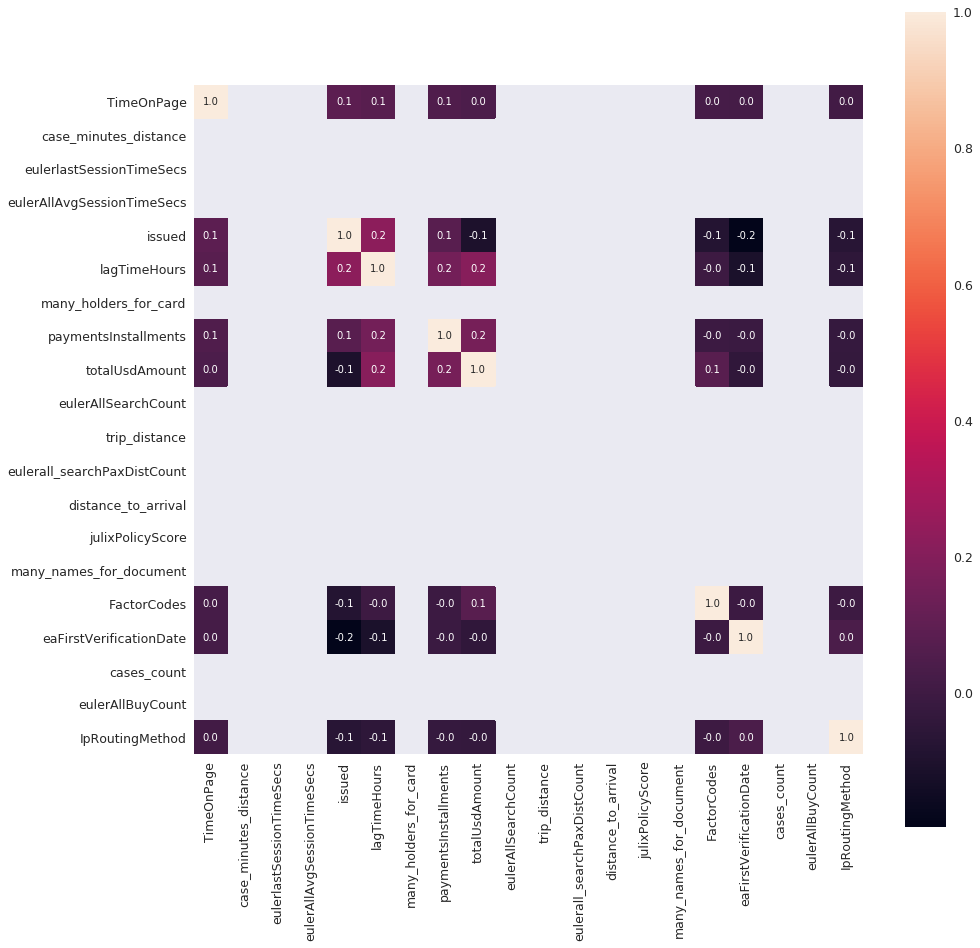

In [105]:
corrmat = train_df.corr()
k = 20 #number of variables for heatmap
cols = corrmat.nlargest(k, 'fraud')['fraud'].index
cm = np.corrcoef(train_df[cols].values.T)
sns.set(font_scale=1.25)
fig, ax = plt.subplots(figsize=(15,15))  
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.1f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)

plt.show()

Chequeo los missing values

In [79]:
total = train_df.isnull().sum().sort_values(ascending=False)
percent = (train_df.isnull().sum()/train_df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
many_names_for_document,38787,0.962266
many_holders_for_card,38416,0.953061
case_minutes_distance,38112,0.945519
count_different_installments,38112,0.945519
count_different_cards,38112,0.945519
eulerFriendsIds,37475,0.929716
domain_proc,18916,0.469286
eulerSocialNetwork,16055,0.398308
TimeOnPage,9776,0.242532
billingCountryCode,9296,0.230624


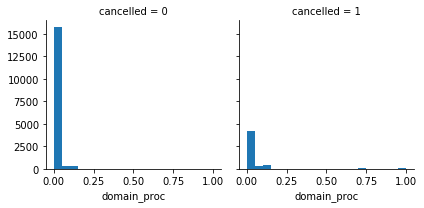

In [104]:

train_df['billingCountryCode'] = train_df.billingCountryCode.astype("category").cat.codes
train_df['eulerSocialNetwork'] = train_df.eulerSocialNetwork.astype("category").cat.codes
g = sns.FacetGrid(train_df, col='cancelled')

g.map(plt.hist, 'billingCountryCode', bins=20)

In [304]:
guess_ages = np.zeros((2,1))
guess_billingCountryCode = np.zeros((2,1))
for j in range(0, 1):
            guess_df = train_df[(train_df['fraud'] == j) ]['TimeOnPage'].dropna()
           
            # age_mean = guess_df.mean()
            # age_std = guess_df.std()
            # age_guess = rnd.uniform(age_mean - age_std, age_mean + age_std)

            age_guess = guess_df.mean()

            # Convert random age float to nearest .5 age
            guess_ages[j] = int( age_guess/0.5 + 0.5 ) * 0.5
           
for j in range(0, 1):
            train_df.loc[ (train_df.TimeOnPage.isnull()) & (train_df.fraud == j) ,\
                    'TimeOnPage'] = guess_ages[j]
           

De billingCountryCode para arriba no los tengo en cuenta por faltar mas de un 15% de los datos

In [305]:
train_df = train_df.drop(['many_names_for_document','many_holders_for_card','case_minutes_distance'
                         ,'count_different_installments','count_different_cards','eulerFriendsIds',
                         'domain_proc','billingCountryCode' ], axis=1)
total = train_df.isnull().sum().sort_values(ascending=False)
percent = (train_df.isnull().sum()/train_df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(30)

,Total,Percent
julixBrowserLanguage,4648,0.115312
TimeOnPage,3072,0.076213
eulerSearchUrgency,2930,0.072690
eulerBadge,2651,0.065769
julixReasonCode,2170,0.053835
eulerBuyPaxDist,1361,0.033765
eulerBuyTripType,1356,0.033641
eulerMobileAppInstalled,1231,0.030540
card_bin_90,1048,0.026000
card_bin_60,1048,0.026000


Ahora casteo los strings

In [47]:
train_df.describe(include=['O'])

,cardCountryCode,caseDate,channel,countryCode,countryFrom,countryTo,eaFirstVerificationDate,eulerBadge,eulerBuyPaxDist,eulerBuyTripType,eulerSearchUrgency,iataFrom,iataTo,ip_city,julixBrowserLanguage,julixOs,julixReasonCode,julixTrueIpCity,julixTrueIpRegion,paymentsCardType,same_field_features
count,40278,40308,40308,40308,40308,40307,40306,37657,38947,38952,37378,40308,40308,39995,35660,39724,38138,39403,39403,40294,40302
unique,63,40239,13,1,82,115,26250,3,44,10,3,341,476,2331,112,9,16,1960,233,7,27612
top,BR,2017-04-18T22:13:52Z,site,BR,BR,BR,2010-01-25T07:00:00Z,BUYER,1|0|0,ROUNDTRIP,INACTIVE,GRU,GRU,SAO,"pt-BR,pt;q",Windows,Flash_Disabled,sao paulo,sao paulo,CA,"{u'same_phone': {}, u'same_ip': {}, u'same_doc..."
freq,39062,2,25213,40308,38335,33550,410,23097,26433,16874,21644,7573,4578,8647,23265,22359,22205,8103,12723,18802,7446


In [36]:
train_df.describe(include=['O']).columns


Index([u'billingCountryCode'], dtype='object')

In [306]:
train_df['cardCountryCode'] = train_df.cardCountryCode.astype("category").cat.codes

train_df['channel'] = train_df.channel.astype("category").cat.codes
train_df['eulerSocialNetwork'] = train_df.eulerSocialNetwork.astype("category").cat.codes

train_df['countryCode'] = train_df.countryCode.astype("category").cat.codes
train_df['countryFrom'] = train_df.countryFrom.astype("category").cat.codes
train_df['countryTo'] = train_df.countryTo.astype("category").cat.codes
#train_df['billingCountryCode'] = train_df.billingCountryCode.astype("category").cat.codes

#train_df['eaFirstVerificationDate'] = train_df.eaFirstVerificationDate.astype("category").cat.codes
train_df['eulerBadge'] = train_df.eulerBadge.astype("category").cat.codes
train_df['eulerBuyPaxDist'] = (train_df['eulerBuyPaxDist'].str.translate(None, '|'))

train_df['eulerBuyTripType'] = train_df.eulerBuyTripType.astype("category").cat.codes
train_df['eulerSearchUrgency'] = train_df.eulerSearchUrgency.astype("category").cat.codes
train_df['iataFrom'] = train_df.iataFrom.astype("category").cat.codes

train_df['iataTo'] = train_df.iataTo.astype("category").cat.codes
train_df['ip_city'] = train_df.ip_city.astype("category").cat.codes


train_df['julixOs'] = train_df.julixOs.astype("category").cat.codes
train_df['julixReasonCode'] = train_df.julixReasonCode.astype("category").cat.codes
train_df['julixTrueIpCity'] = train_df.julixTrueIpCity.astype("category").cat.codes
train_df['julixBrowserLanguage'] = train_df.julixBrowserLanguage.astype("category").cat.codes
train_df['julixTrueIpRegion'] = train_df.julixTrueIpRegion.astype("category").cat.codes
train_df['paymentsCardType'] = train_df.paymentsCardType.astype("category").cat.codes
train_df['same_field_features'] = train_df.same_field_features.astype("category").cat.codes

Relleno los datos faltantes con 0

In [307]:
## COMPLETO JULIX BROWSER EN BASE A SU CAMPO MAS CORRELACIONADO
guess_ages = np.zeros((13,1))

for j in range(0, 12):
            guess_df = train_df[(train_df['channel'] == j) ]['julixBrowserLanguage'].dropna()
           
            # age_mean = guess_df.mean()
            # age_std = guess_df.std()
            # age_guess = rnd.uniform(age_mean - age_std, age_mean + age_std)

            age_guess = guess_df.mean()

            # Convert random age float to nearest .5 age
            guess_ages[j] = int( age_guess/0.5 + 0.5 ) * 0.5
           
for j in range(0, 1):
            train_df.loc[ (train_df.julixBrowserLanguage.isnull()) & (train_df.channel == j) ,\
                    'julixBrowserLanguage'] = guess_ages[j]

In [308]:
df_filtered = train_df

df_filtered['hours_since_first_verification'].fillna(df_filtered['hours_since_first_verification'].dropna().mean(), inplace=True)

#df_filtered['julixBrowserLanguage'].fillna(df_filtered['julixBrowserLanguage'].dropna().median(), inplace=True)
df_filtered['eulerSearchUrgency'].fillna(df_filtered['eulerSearchUrgency'].dropna().median(), inplace=True)
df_filtered['eulerBadge'].fillna(df_filtered['eulerBadge'].dropna().median(), inplace=True)
df_filtered['julixReasonCode'].fillna(df_filtered['julixReasonCode'].dropna().median(), inplace=True)
df_filtered['eulerBuyPaxDist'].fillna(df_filtered['eulerBuyPaxDist'].dropna().median(), inplace=True)
df_filtered['eulerBuyTripType'].fillna(df_filtered['eulerBuyTripType'].dropna().median(), inplace=True)
df_filtered['eulerMobileAppInstalled'].fillna(df_filtered['eulerMobileAppInstalled'].dropna().median(), inplace=True)

df_filtered['card_bin_1'].fillna(df_filtered['card_bin_1'].dropna().median(), inplace=True)
df_filtered['card_bin_30'].fillna(df_filtered['card_bin_30'].dropna().median(), inplace=True)
df_filtered['card_bin_60'].fillna(df_filtered['card_bin_60'].dropna().median(), inplace=True)
df_filtered['card_bin_90'].fillna(df_filtered['card_bin_90'].dropna().median(), inplace=True)
df_filtered.update(df_filtered[df_filtered.columns].fillna(0))
df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40308 entries, 0 to 40307
Data columns (total 85 columns):
id                                40308 non-null int64
AfsScore                          40308 non-null float64
DeviceMatch                       40308 non-null int64
FactorCodes                       40308 non-null int64
FirstEncounter                    40308 non-null int64
IcAddress                         40308 non-null int64
IcInternet                        40308 non-null int64
IcSuspicious                      40308 non-null int64
IcVelocity                        40308 non-null int64
Icidentity                        40308 non-null int64
IpRoutingMethod                   40308 non-null int64
ReasonCode                        40308 non-null float64
TimeOnPage                        40308 non-null float64
cancelled                         40308 non-null int64
cardCountryCode                   40308 non-null int8
card_bin_1                        40308 non-null float64
card

In [298]:
X.shape

(37236, 84)

Chequeo correlaciones

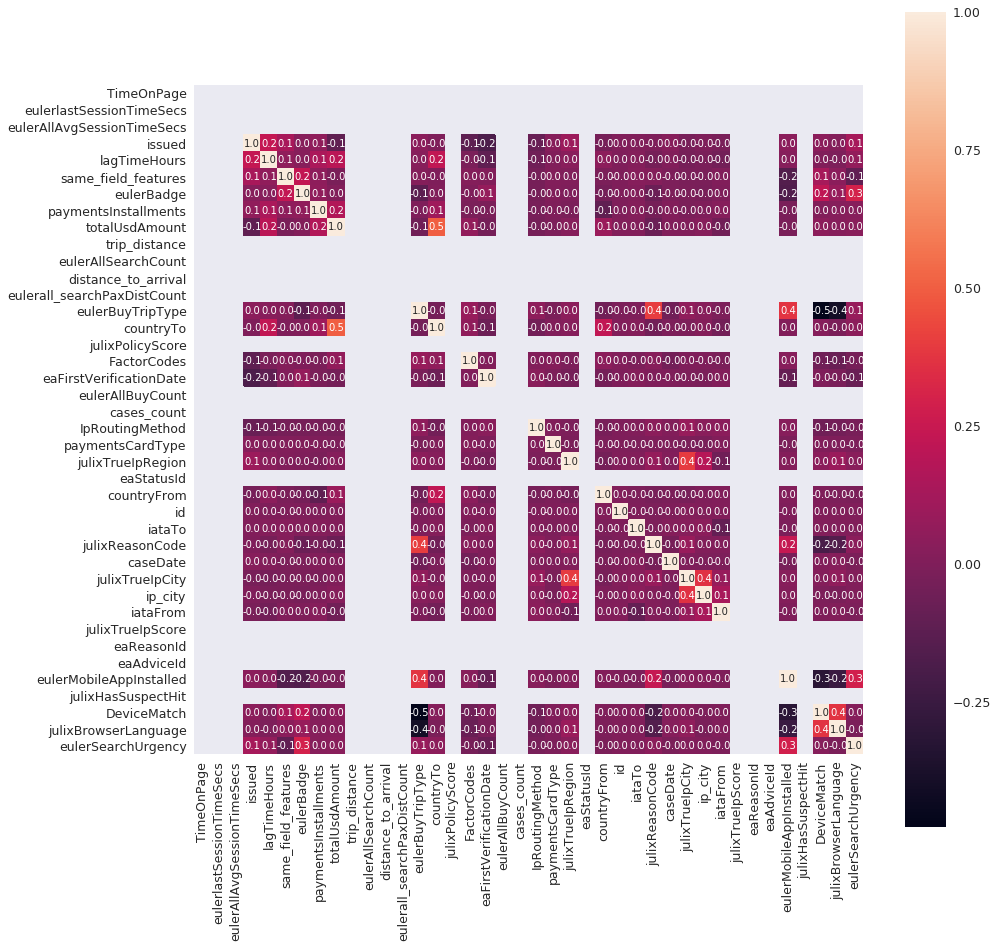

Index([u'TimeOnPage', u'eulerlastSessionTimeSecs',
       u'eulerAllAvgSessionTimeSecs', u'issued', u'lagTimeHours',
       u'same_field_features', u'eulerBadge', u'paymentsInstallments',
       u'totalUsdAmount', u'trip_distance', u'eulerAllSearchCount',
       u'distance_to_arrival', u'eulerall_searchPaxDistCount',
       u'eulerBuyTripType', u'countryTo', u'julixPolicyScore', u'FactorCodes',
       u'eaFirstVerificationDate', u'eulerAllBuyCount', u'cases_count',
       u'IpRoutingMethod', u'paymentsCardType', u'julixTrueIpRegion',
       u'eaStatusId', u'countryFrom', u'id', u'iataTo', u'julixReasonCode',
       u'caseDate', u'julixTrueIpCity', u'ip_city', u'iataFrom',
       u'julixTrueIpScore', u'eaReasonId', u'eaAdviceId',
       u'eulerMobileAppInstalled', u'julixHasSuspectHit', u'DeviceMatch',
       u'julixBrowserLanguage', u'eulerSearchUrgency'],
      dtype='object')

In [301]:
corrmat = df_filtered.corr()
k = 40 #number of variables for heatmap
cols = corrmat.nlargest(k, 'fraud')['fraud'].index
cm = np.corrcoef(df_filtered[cols].values.T)
sns.set(font_scale=1.25)
fig, ax = plt.subplots(figsize=(15,15))  
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.1f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)

plt.show()
cols

In [309]:
df_filtered['card_bin'] = df_filtered['card_bin_30'] * df_filtered['card_bin_60'] * df_filtered['card_bin_90']
df_filtered['online'] = df_filtered['online_ip_state'] * df_filtered['online_cep_number_bond'] * df_filtered['online_state_bond'] * df_filtered['online_ddd_bond']* df_filtered['online_death']*df_filtered['online_phone']*df_filtered['online_family_bond']*df_filtered['online_name']
df_filtered = df_filtered.drop(['card_bin_30','card_bin_60','card_bin_90','online_ip_state','online_cep_number_bond','online_state_bond','online_ddd_bond','online_death','julixOs','eaStatusId','online_family_bond','online_queries','online_billing_address_state','id'
                          ], axis=1)

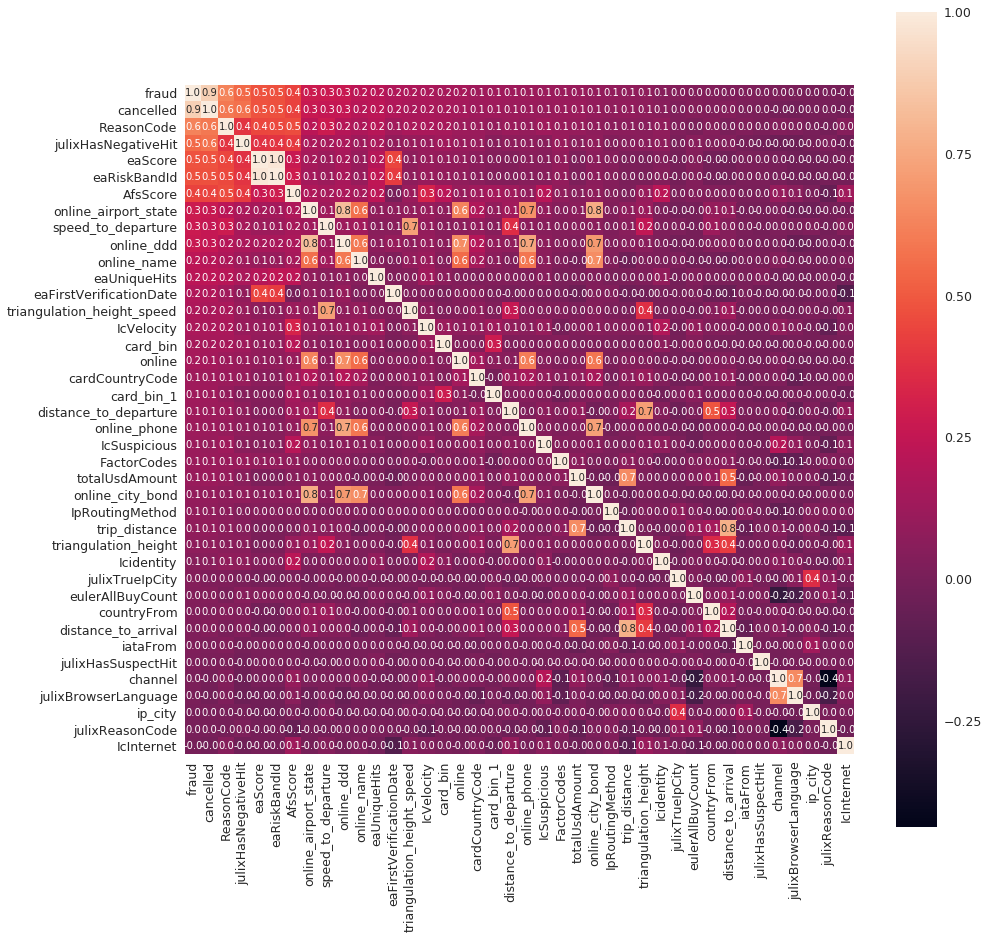

Index([u'fraud', u'cancelled', u'ReasonCode', u'julixHasNegativeHit',
       u'eaScore', u'eaRiskBandId', u'AfsScore', u'online_airport_state',
       u'speed_to_departure', u'online_ddd', u'online_name', u'eaUniqueHits',
       u'eaFirstVerificationDate', u'triangulation_height_speed',
       u'IcVelocity', u'card_bin', u'online', u'cardCountryCode',
       u'card_bin_1', u'distance_to_departure', u'online_phone',
       u'IcSuspicious', u'FactorCodes', u'totalUsdAmount', u'online_city_bond',
       u'IpRoutingMethod', u'trip_distance', u'triangulation_height',
       u'Icidentity', u'julixTrueIpCity', u'eulerAllBuyCount', u'countryFrom',
       u'distance_to_arrival', u'iataFrom', u'julixHasSuspectHit', u'channel',
       u'julixBrowserLanguage', u'ip_city', u'julixReasonCode', u'IcInternet'],
      dtype='object')

In [310]:
corrmat = df_filtered.corr()
k = 40 #number of variables for heatmap
cols = corrmat.nlargest(k, 'fraud')['fraud'].index
cm = np.corrcoef(df_filtered[cols].values.T)
sns.set(font_scale=1.25)
fig, ax = plt.subplots(figsize=(15,15))  
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.1f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)

plt.show()


In [311]:
df_filtered['importants'] = df_filtered['cancelled'] * df_filtered['ReasonCode'] * df_filtered['julixHasNegativeHit'] * df_filtered['eaScore']


Veamos si graficando en 2D se ve la diferencia entre fraudes y no fraude

In [8]:
from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD
fmd = df_filtered.drop("fraud", axis=1)
svd = TruncatedSVD(n_components=8, n_iter=200, random_state=42)
svd.fit(fmd.T)
X_embedded = TSNE(n_components=2).fit_transform(svd.components_.T)

KeyboardInterrupt: 

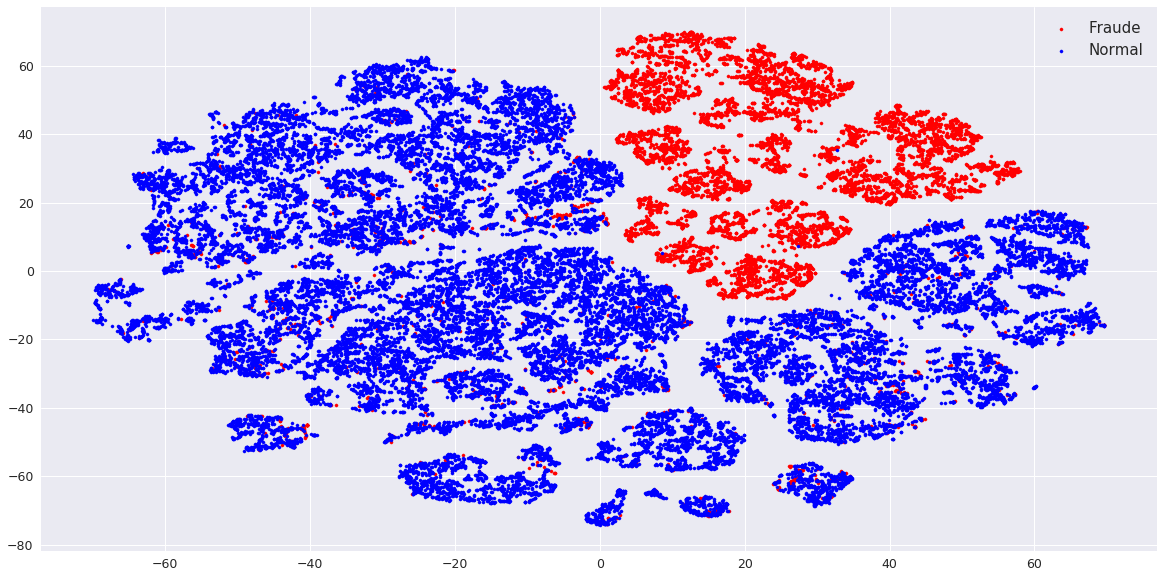

In [82]:
from matplotlib import pyplot as plt
fraud = df_filtered['fraud']
plt.figure(figsize=(20,10))
plt.scatter(X_embedded[fraud[:]==1,0], X_embedded[fraud[:]==1,1], color='red', s=10, label="Fraude")
plt.scatter(X_embedded[fraud[:]==0,0], X_embedded[fraud[:]==0,1], color='blue', s=10, label="Normal")
plt.legend( prop={'size': 15})
plt.show()

## Algoritmos clasicos

In [8]:
from sklearn.model_selection import train_test_split
def clasificadores(X,y):
    X, X_test, y, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
    knn = KNeighborsClassifier(n_neighbors = 3)
    knn.fit(X, y)

    acc_knn = round(knn.score(X_test, y_test) * 100, 2)


    random_forest = RandomForestClassifier(n_estimators=100)
    random_forest.fit(X, y)

    acc_random_forest = round(random_forest.score(X_test, y_test) * 100, 2)


    gaussian = GaussianNB()
    gaussian.fit(X, y)

    acc_gaussian = round(gaussian.score(X_test, y_test) * 100, 2)


    logreg = LogisticRegression()
    logreg.fit(X, y)

    acc_log = round(logreg.score(X_test, y_test) * 100, 2)


    svc = SVC()
    svc.fit(X, y)

    acc_svc = round(svc.score(X_test, y_test) * 100, 2)


    decision_tree = DecisionTreeClassifier()
    decision_tree.fit(X, y)

    acc_decision_tree = round(decision_tree.score(X_test, y_test) * 100, 2)
    return [acc_svc, acc_knn, acc_log, acc_random_forest, acc_gaussian, acc_decision_tree]



In [11]:
X = df_filtered.drop("fraud", axis=1)
y = df_filtered.filter(items=["fraud"])
obvio = clasificadores(X,y)



models = pd.DataFrame({
    'Clasificador': ['Support Vector Machines', 'KNN', 'Logistic Regression', 
              'Random Forest', 'Naive Bayes', 
              'Decision Tree'],
    'Obvio': obvio})
models[['Clasificador','Obvio']].sort_values(by='Obvio', ascending=False)

/home/juanma/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  """
/home/juanma/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
/home/juanma/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


,Clasificador,Obvio
3,Random Forest,98.29
5,Decision Tree,95.76
2,Logistic Regression,95.04
4,Naive Bayes,85.29
1,KNN,82.78
0,Support Vector Machines,75.89


In [68]:
from sklearn.decomposition import PCA
x = df_filtered.drop("fraud", axis=1)
pca = PCA(84)
# fit on data
pca.fit(x)

X_embedded = pca.transform(x)
X = X_embedded
y = df_filtered.filter(items=["fraud"])
from sklearn.model_selection import train_test_split
#train_df.voto_cambiemos_reducido.unique()
X.shape

ValueError: n_components=84 must be between 0 and n_features=62 with svd_solver='full'

Random Forest la rompio

In [312]:

X = df_filtered.drop("fraud", axis=1)
y = df_filtered.filter(items=["fraud"])
X, X_test, y, y_test = train_test_split(X, y, test_size=0.03, random_state=42)
random_forest = RandomForestClassifier(n_estimators=800,bootstrap=False)
random_forest.fit(X, y)
acc_random_forest = round(random_forest.score(X_test, y_test) * 100, 2)
acc_random_forest

/home/juanma/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


98.84

In [93]:
X = df_filtered.drop("fraud", axis=1)
y = df_filtered.filter(items=["fraud"])
X, X_test, y, y_test = train_test_split(X, y, test_size=0.02, random_state=42)
X.shape

(39501, 80)

In [31]:
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, VotingClassifier,GradientBoostingClassifier
clf1 = RandomForestClassifier(n_estimators=500)
clf2 = GradientBoostingClassifier(n_estimators=500,max_depth=8)

df_filtered_2 = df_filtered
X = df_filtered_2.drop("fraud", axis=1)
y = df_filtered_2.filter(items=["fraud"])
X, X_test, y, y_test = train_test_split(X, y, test_size=0.09, random_state=42)
aboost = VotingClassifier(estimators=[('lr', clf1), ('rf', clf2)],voting='soft')
aboost.fit(X, y)
acc_gboost = round(aboost.score(X_test, y_test) * 100, 2)
acc_gboost

/home/juanma/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/juanma/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/juanma/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


98.98

In [246]:
test_df = pd.read_csv('test.csv')
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20364 entries, 0 to 20363
Data columns (total 93 columns):
id                                20364 non-null int64
AfsScore                          20364 non-null float64
DeviceMatch                       20364 non-null int64
FactorCodes                       20364 non-null int64
FirstEncounter                    20364 non-null int64
IcAddress                         20364 non-null int64
IcInternet                        20364 non-null int64
IcSuspicious                      20364 non-null int64
IcVelocity                        20364 non-null int64
Icidentity                        20364 non-null int64
IpRoutingMethod                   20364 non-null int64
ReasonCode                        20364 non-null float64
TimeOnPage                        15871 non-null float64
billingCountryCode                16737 non-null object
cancelled                         20364 non-null int64
cardCountryCode                   20357 non-null object
car

Le aplico las mismas transformaciones al set de prueba

In [247]:
guess_ages = np.zeros((2,1))
for j in range(0, 1):
            guess_df = test_df[(test_df['cancelled'] == j) ]['TimeOnPage'].dropna()

            # age_mean = guess_df.mean()
            # age_std = guess_df.std()
            # age_guess = rnd.uniform(age_mean - age_std, age_mean + age_std)

            age_guess = guess_df.mean()

            # Convert random age float to nearest .5 age
            guess_ages[j] = int( age_guess/0.5 + 0.5 ) * 0.5
for j in range(0, 1):
            test_df.loc[ (test_df.TimeOnPage.isnull()) & (test_df.cancelled == j) ,\
                    'TimeOnPage'] = guess_ages[j]
        
## COMPLETO JULIX BROWSER EN BASE A SU CAMPO MAS CORRELACIONADO
guess_ages = np.zeros((13,1))


#Relleno las billingcountrycode faltantes con el country code de la tarjeta
#train_df['billingCountryCode'].fillna(train_df['cardCountryCode'], inplace=True)
#agrego la red social "desconocida"
test_df['eulerSocialNetwork'].fillna(0, inplace=True)
test_df['eulerSocialNetwork'] = test_df.eulerSocialNetwork.astype("category").cat.codes
##casteo las fechas
test_df['hours_since_first_verification'] = (pd.to_datetime(test_df['caseDate']) - pd.to_datetime(test_df['eaFirstVerificationDate'])).astype('timedelta64[h]')
test_df['caseDate'] = pd.to_datetime(test_df['caseDate']).dt.hour
#calculo los valores faltantes de esta columna
test_df['eaFirstVerificationDate'] = pd.to_datetime(test_df['eaFirstVerificationDate']).values.astype(np.int64) // 10 ** 9

test_df = test_df.drop(['many_names_for_document','many_holders_for_card','case_minutes_distance'
                         ,'count_different_installments','count_different_cards','eulerFriendsIds',
                         'domain_proc','billingCountryCode' ], axis=1)
test_df['cardCountryCode'] = test_df.cardCountryCode.astype("category").cat.codes
#test_df['caseDate'] = test_df.caseDate.astype("category").cat.codes
test_df['channel'] = test_df.channel.astype("category").cat.codes

test_df['countryCode'] = test_df.countryCode.astype("category").cat.codes
test_df['countryFrom'] = test_df.countryFrom.astype("category").cat.codes
test_df['countryTo'] = test_df.countryTo.astype("category").cat.codes

#test_df['eaFirstVerificationDate'] = test_df.eaFirstVerificationDate.astype("category").cat.codes
test_df['eulerBadge'] = test_df.eulerBadge.astype("category").cat.codes
test_df['eulerBuyPaxDist'] = (test_df['eulerBuyPaxDist'].str.translate(None, '|'))

test_df['eulerBuyTripType'] = test_df.eulerBuyTripType.astype("category").cat.codes
test_df['eulerSearchUrgency'] = test_df.eulerSearchUrgency.astype("category").cat.codes
test_df['iataFrom'] = test_df.iataFrom.astype("category").cat.codes

test_df['iataTo'] = test_df.iataTo.astype("category").cat.codes
test_df['ip_city'] = test_df.ip_city.astype("category").cat.codes
test_df['julixBrowserLanguage'] = test_df.julixBrowserLanguage.astype("category").cat.codes

test_df['julixOs'] = test_df.julixOs.astype("category").cat.codes
test_df['julixReasonCode'] = test_df.julixReasonCode.astype("category").cat.codes
test_df['julixTrueIpCity'] = test_df.julixTrueIpCity.astype("category").cat.codes

test_df['julixTrueIpRegion'] = test_df.julixTrueIpRegion.astype("category").cat.codes
test_df['paymentsCardType'] = test_df.paymentsCardType.astype("category").cat.codes
test_df['same_field_features'] = test_df.same_field_features.astype("category").cat.codes

for j in range(0, 12):
            guess_df = train_df[(train_df['channel'] == j) ]['julixBrowserLanguage'].dropna()
           
            # age_mean = guess_df.mean()
            # age_std = guess_df.std()
            # age_guess = rnd.uniform(age_mean - age_std, age_mean + age_std)

            age_guess = guess_df.mean()

            # Convert random age float to nearest .5 age
            guess_ages[j] = int( age_guess/0.5 + 0.5 ) * 0.5
           
for j in range(0, 1):
            train_df.loc[ (train_df.julixBrowserLanguage.isnull()) & (train_df.channel == j) ,\
                    'julixBrowserLanguage'] = guess_ages[j]

test_df['hours_since_first_verification'].fillna(test_df['hours_since_first_verification'].dropna().mean(), inplace=True)

#test_df['julixBrowserLanguage'].fillna(test_df['julixBrowserLanguage'].dropna().median(), inplace=True)
test_df['eulerSearchUrgency'].fillna(test_df['eulerSearchUrgency'].dropna().median(), inplace=True)
test_df['eulerBadge'].fillna(test_df['eulerBadge'].dropna().median(), inplace=True)
test_df['julixReasonCode'].fillna(test_df['julixReasonCode'].dropna().median(), inplace=True)
test_df['eulerBuyPaxDist'].fillna(test_df['eulerBuyPaxDist'].dropna().median(), inplace=True)
test_df['eulerBuyTripType'].fillna(test_df['eulerBuyTripType'].dropna().median(), inplace=True)
test_df['eulerMobileAppInstalled'].fillna(test_df['eulerMobileAppInstalled'].dropna().median(), inplace=True)

test_df['card_bin_1'].fillna(test_df['card_bin_1'].dropna().median(), inplace=True)
test_df['card_bin_30'].fillna(test_df['card_bin_30'].dropna().median(), inplace=True)
test_df['card_bin_60'].fillna(test_df['card_bin_60'].dropna().median(), inplace=True)
test_df['card_bin_90'].fillna(test_df['card_bin_90'].dropna().median(), inplace=True)
test_df['card_bin'] = test_df['card_bin_30'] * test_df['card_bin_60'] * test_df['card_bin_90']
test_df['online'] = test_df['online_ip_state'] * test_df['online_cep_number_bond'] * test_df['online_state_bond'] * test_df['online_ddd_bond']* test_df['online_death']*test_df['online_phone']*test_df['online_family_bond']*test_df['online_name']
test_df['importants'] = test_df['cancelled'] * test_df['ReasonCode'] * test_df['julixHasNegativeHit'] * test_df['eaScore']

test_df = test_df.drop(['card_bin_30','card_bin_60','card_bin_90','online_ip_state','online_cep_number_bond','online_state_bond','online_ddd_bond','online_death','julixOs','eaStatusId','online_family_bond','online_queries','online_billing_address_state'
                          ], axis=1)



test_df.update(test_df[test_df.columns].fillna(0))
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20364 entries, 0 to 20363
Data columns (total 75 columns):
id                                20364 non-null int64
AfsScore                          20364 non-null float64
DeviceMatch                       20364 non-null int64
FactorCodes                       20364 non-null int64
FirstEncounter                    20364 non-null int64
IcAddress                         20364 non-null int64
IcInternet                        20364 non-null int64
IcSuspicious                      20364 non-null int64
IcVelocity                        20364 non-null int64
Icidentity                        20364 non-null int64
IpRoutingMethod                   20364 non-null int64
ReasonCode                        20364 non-null float64
TimeOnPage                        20364 non-null float64
cancelled                         20364 non-null int64
cardCountryCode                   20364 non-null int8
card_bin_1                        20364 non-null float64
case

In [155]:
X_test  = test_df.drop("fraud", axis=1).copy()
predicted = aboost.predict_proba(X_test)
predictions = [round(x[1],2) for x in predicted]
predictions

[0.99,
 0.03,
 0.99,
 0.02,
 0.02,
 0.42,
 0.03,
 0.01,
 0.03,
 0.02,
 1.0,
 0.04,
 0.02,
 0.3,
 0.02,
 0.09,
 0.99,
 1.0,
 1.0,
 0.01,
 0.27,
 0.99,
 0.01,
 0.04,
 0.99,
 0.13,
 0.01,
 0.03,
 0.27,
 0.01,
 0.13,
 0.0,
 0.38,
 0.97,
 0.01,
 0.02,
 0.98,
 0.99,
 0.14,
 0.66,
 0.99,
 0.22,
 0.01,
 0.98,
 0.02,
 0.02,
 0.01,
 0.02,
 0.03,
 0.42,
 0.13,
 0.01,
 0.0,
 0.01,
 0.03,
 0.01,
 0.04,
 0.1,
 0.99,
 0.01,
 0.04,
 0.01,
 0.06,
 0.02,
 0.98,
 0.19,
 0.05,
 0.01,
 0.35,
 0.0,
 0.02,
 0.01,
 0.99,
 0.99,
 0.99,
 0.01,
 0.21,
 0.04,
 0.99,
 0.02,
 0.99,
 0.98,
 0.01,
 0.15,
 0.07,
 0.99,
 0.99,
 0.99,
 0.02,
 0.99,
 0.14,
 0.04,
 1.0,
 0.05,
 0.02,
 1.0,
 0.99,
 0.98,
 0.07,
 0.06,
 0.98,
 0.04,
 0.02,
 0.02,
 0.01,
 0.03,
 0.04,
 0.11,
 0.99,
 0.97,
 0.01,
 0.99,
 0.04,
 0.06,
 0.98,
 0.01,
 0.12,
 0.04,
 0.99,
 0.03,
 0.02,
 0.01,
 0.33,
 0.0,
 0.13,
 0.07,
 0.02,
 0.63,
 0.99,
 0.05,
 0.98,
 0.05,
 0.98,
 0.99,
 0.09,
 0.13,
 0.02,
 0.99,
 0.57,
 0.01,
 0.1,
 0.01,
 0.01,
 0.11,
 0.0

In [248]:
X_test  = test_df.drop(["fraud",'id'], axis=1).copy()
predicted = random_forest.predict_proba(X_test)
predictions = [round(x[1],2) for x in predicted]
predictions

[1.0,
 0.01,
 0.97,
 0.01,
 0.01,
 0.16,
 0.04,
 0.01,
 0.04,
 0.0,
 1.0,
 0.07,
 0.01,
 0.09,
 0.0,
 0.13,
 0.98,
 0.99,
 0.99,
 0.01,
 0.53,
 0.99,
 0.01,
 0.07,
 0.97,
 0.11,
 0.0,
 0.04,
 0.13,
 0.02,
 0.16,
 0.01,
 0.16,
 0.97,
 0.01,
 0.01,
 0.98,
 0.99,
 0.08,
 0.37,
 0.98,
 0.11,
 0.03,
 0.98,
 0.02,
 0.01,
 0.0,
 0.0,
 0.06,
 0.55,
 0.05,
 0.0,
 0.0,
 0.01,
 0.05,
 0.0,
 0.03,
 0.07,
 0.99,
 0.0,
 0.04,
 0.0,
 0.08,
 0.02,
 0.98,
 0.12,
 0.06,
 0.01,
 0.13,
 0.01,
 0.03,
 0.01,
 0.98,
 0.97,
 0.98,
 0.02,
 0.07,
 0.04,
 0.98,
 0.02,
 0.97,
 0.97,
 0.02,
 0.07,
 0.13,
 0.98,
 0.98,
 0.98,
 0.01,
 0.99,
 0.09,
 0.07,
 1.0,
 0.07,
 0.02,
 0.99,
 0.99,
 0.98,
 0.07,
 0.13,
 0.97,
 0.07,
 0.02,
 0.01,
 0.06,
 0.14,
 0.03,
 0.09,
 0.99,
 0.97,
 0.01,
 0.98,
 0.06,
 0.19,
 0.94,
 0.01,
 0.08,
 0.06,
 0.99,
 0.05,
 0.05,
 0.0,
 0.1,
 0.0,
 0.23,
 0.1,
 0.01,
 0.24,
 0.98,
 0.07,
 0.99,
 0.11,
 0.95,
 0.99,
 0.1,
 0.06,
 0.03,
 0.98,
 0.14,
 0.0,
 0.08,
 0.01,
 0.01,
 0.12,
 0.0,
 0.01

In [249]:

submission = pd.DataFrame({
        "Id": test_df["id"],
        "Fraud": predictions
    })
submission[['Id','Fraud']].to_csv('submission.csv', index=False, header=False)

## Red Neuronal

In [37]:
%load_ext autoreload
%autoreload 2
from IPython.display import HTML
import reg_helper as RHelper
import numpy as np
import draw_nn
from matplotlib import pyplot as plt 
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint 
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.normalization import BatchNormalization
from keras import optimizers
from keras import initializers
from fnn_helper import PlotLosses
from keras import optimizers

/home/juanma/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [55]:
from sklearn.decomposition import PCA
x = df_filtered.drop("fraud", axis=1)
pca = PCA(60)
# fit on data
pca.fit(x)

X_embedded = pca.transform(x)
X = X_embedded
y = df_filtered.filter(items=["fraud"])
from sklearn.model_selection import train_test_split
#train_df.voto_cambiemos_reducido.unique()
X.shape

(40308, 60)

In [39]:
X = df_filtered.drop("fraud", axis=1)
y = df_filtered.filter(items=["fraud"])

In [56]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils
encoder = LabelEncoder()
encoder.fit(y)
encoded_Y = encoder.transform(y)
# convert integers to dummy variables (i.e. one hot encoded)
dummy_y = np_utils.to_categorical(encoded_Y)
X_train, X_test, y_train, y_test= train_test_split(X, dummy_y, test_size=0.1, random_state=42)
X_train.shape

(36277, 60)

In [57]:
epochs = 500 #adam 3000, sgd 30000
lr=0.001
decay=0
input_shape = 60
hidden_units = 300 # Probar con 3, 10, 20, 200
output_size = 2
p = 0.3
batch_size = 1024 # 10 y 59

optim = optimizers.adam(lr=lr, decay=0.1)
#optim = optimizers.rmsprop(lr=lr, decay=0.001)

default_initializer = 'he_normal'
# Creo el modelo
model_single_layer = Sequential()
model_single_layer.add(Dense(hidden_units, input_dim=input_shape, kernel_initializer=default_initializer,bias_initializer='Zeros',activation="relu"))
model_single_layer.add(BatchNormalization())
model_single_layer.add(Dropout(p))
model_single_layer.add(Dense(hidden_units, kernel_initializer=default_initializer,bias_initializer='Zeros', name='Hidden',activation="relu"))
model_single_layer.add(BatchNormalization())
model_single_layer.add(Dropout(p))
model_single_layer.add(Dense(hidden_units, kernel_initializer=default_initializer,bias_initializer='Zeros', name='Hidden2',activation="relu"))
model_single_layer.add(BatchNormalization())
model_single_layer.add(Dropout(p))

model_single_layer.add(Dense(output_size, kernel_initializer=default_initializer,bias_initializer='Zeros', name='Salida'))
model_single_layer.add(Activation('softmax'))
model_single_layer.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 300)               18300     
_________________________________________________________________
batch_normalization_16 (Batc (None, 300)               1200      
_________________________________________________________________
dropout_14 (Dropout)         (None, 300)               0         
_________________________________________________________________
Hidden (Dense)               (None, 300)               90300     
_________________________________________________________________
batch_normalization_17 (Batc (None, 300)               1200      
_________________________________________________________________
dropout_15 (Dropout)         (None, 300)               0         
_________________________________________________________________
Hidden2 (Dense)              (None, 300)               90300     
__________

In [58]:
model_single_layer.compile(loss='categorical_crossentropy', optimizer=optim, metrics=['accuracy'])

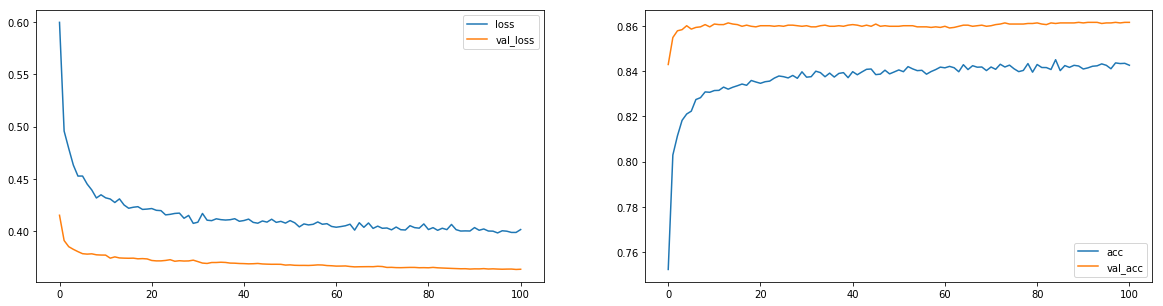

KeyboardInterrupt: 

In [59]:
optim = optimizers.rmsprop(lr=lr, decay=0.08)
model_single_layer.compile(loss='categorical_crossentropy', optimizer=optim, metrics=['accuracy'])
plot_losses = PlotLosses(plot_interval=50, evaluate_interval=None, x_val=X_test, y_val_categorical=y_test)
checkpointer = ModelCheckpoint(filepath='model_despegar.hdf5', verbose=0, save_best_only=True)
model_single_layer.fit(X_train, 
          y_train, batch_size = batch_size,
          epochs=epochs, 
          verbose=0, 
          validation_data=(X_test, y_test), 
          callbacks=[plot_losses, checkpointer],
         )

In [41]:
model_single_layer.load_weights('model_despegar.hdf5')
loss, acc = model_single_layer.evaluate(X_test, y_test)

8062/8062 [==============================] - 0s 22us/step


In [42]:
print(acc)

0.876581493455522


## CNN

In [8]:
%load_ext autoreload
%autoreload 2
from IPython.display import HTML
import reg_helper as RHelper
import numpy as np
import draw_nn
from matplotlib import pyplot as plt 
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint 
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.normalization import BatchNormalization
from keras import optimizers
from keras import initializers
from fnn_helper import PlotLosses

/home/juanma/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [9]:
X = df_filtered.drop("fraud", axis=1)
y = df_filtered.filter(items=["fraud"])
X = np.expand_dims(X, axis=2)
from sklearn.model_selection import train_test_split
#train_df.voto_cambiemos_reducido.unique()
X.shape

(40308, 82, 1)

In [10]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils
encoder = LabelEncoder()
encoder.fit(y)
encoded_Y = encoder.transform(y)
# convert integers to dummy variables (i.e. one hot encoded)
dummy_y = np_utils.to_categorical(encoded_Y)
X_train, X_test, y_train, y_test= train_test_split(X, dummy_y, test_size=0.2, random_state=42)
dummy_y.shape

/home/juanma/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/juanma/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(40308, 2)

In [22]:
from keras.layers import Convolution2D, MaxPooling2D, GlobalAveragePooling2D,Conv2D,Conv1D
p = 0.25
default_initializer = 'RandomUniform'
model3=Sequential()

model3.add(Conv1D(filters=25, kernel_size=2, padding="valid", name='Conv1',input_shape=(82,1)))
model3.add(BatchNormalization())
model3.add(Activation('tanh'))
model3.add(Dropout(p))
model3.add(Conv1D(filters=25, kernel_size=3, padding="same", name='Conv2'))
model3.add(BatchNormalization())
model3.add(Activation('tanh'))
model3.add(Dropout(p))


model3.add(Conv1D(filters=25, kernel_size=4, padding="same", name='Conv3'))
model3.add(BatchNormalization())
model3.add(Activation('tanh'))
model3.add(Dropout(p))
model3.add(Flatten())

model3.add(Dense(100, kernel_initializer=default_initializer,bias_initializer=default_initializer))

model3.add(Activation('tanh'))

model3.add(Dense(100, kernel_initializer=default_initializer,bias_initializer=default_initializer))

model3.add(Activation('tanh'))

model3.add(Dense(2, activation='softmax'))

In [23]:
epochs = 10
#lr = 0.00000001
lr = 0.01
#optim = optimizers.sgd(lr=lr)
#optim = optimizers.adam(lr=lr, decay=0.0002)
optim = optimizers.rmsprop(lr=lr, decay=0.01)
model3.compile(loss = 'categorical_crossentropy', optimizer=optim, metrics=['accuracy'])

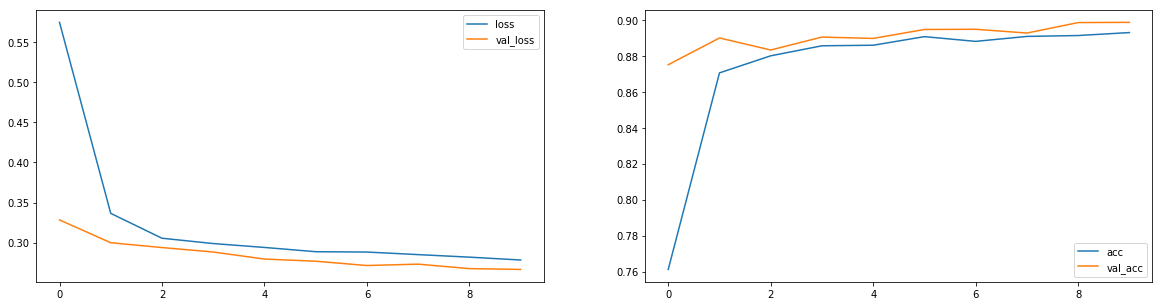


Epoch 00010: val_loss improved from 0.26748 to 0.26644, saving model to cnn1.hdf5


In [24]:
batch_size = 256

checkpointer = ModelCheckpoint(filepath='cnn1.hdf5', verbose=1, save_best_only=True)
plot_losses = PlotLosses(plot_interval=1, evaluate_interval=None, x_val=X_test, y_val_categorical=y_test)

model3.fit(X_train, 
          y_train,
          epochs=epochs, batch_size=batch_size, 
          #verbose=1, 
          validation_data=(X_test, y_test), 
          callbacks=[plot_losses, checkpointer],
         )

In [44]:
test_df = pd.read_csv('test.csv')
df_filtered_test = test_df.filter(items=['AfsScore',
'DeviceMatch',
'FactorCodes',
'FirstEncounter',
'IcAddress',
'IcInternet',
'IcSuspicious',
'IcVelocity',
'Icidentity',
'IpRoutingMethod',
'ReasonCode',
'TimeOnPage',
'eaReasonId',
'eaRiskBandId',
'eaScore',
'eaStatusId',
'eaUniqueHits',
'eulerAllAvgSessionTimeSecs',
'eulerAllBuyCount',
'eulerAllSearchCount',
'online_airport_state',
'online_billing_address_state',
'online_cep_number_bond',
'online_city_bond',
'online_ddd',
'online_ddd_bond',
'online_death',
'online_email',
'online_family_bond',
'online_ip_state',
'online_name',
'online_phone',
'online_queries',
'online_state_bond',
'fraud',
'cancelled'
])
df_filtered_test['TimeOnPage'] = df_filtered_test['TimeOnPage'].fillna(0).astype(int)
df_filtered_test['AfsScore'] = df_filtered_test['AfsScore'].fillna(0).astype(int)
df_filtered_test['ReasonCode'] = df_filtered_test['ReasonCode'].fillna(0).astype(int)
df_filtered_test['eaStatusId'] = df_filtered_test['eaStatusId'].fillna(0).astype(int)
df_filtered_test['eaUniqueHits'] = df_filtered_test['eaUniqueHits'].fillna(0).astype(int)
df_filtered_test['eulerAllAvgSessionTimeSecs'] = df_filtered_test['eulerAllAvgSessionTimeSecs'].fillna(0).astype(int)
df_filtered_test['eulerAllBuyCount'] = df_filtered_test['eulerAllBuyCount'].fillna(0).astype(int)
df_filtered_test['eulerAllSearchCount'] = df_filtered_test['eulerAllSearchCount'].fillna(0).astype(int)

df_filtered_test['eaReasonId'] = df_filtered_test['eaReasonId'].fillna(0).astype(int)
df_filtered_test['eaRiskBandId'] = df_filtered_test['eaRiskBandId'].fillna(0).astype(int)
df_filtered_test['eaScore'] = df_filtered_test['eaScore'].fillna(0).astype(int)

df_filtered_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20364 entries, 0 to 20363
Data columns (total 36 columns):
AfsScore                        20364 non-null int64
DeviceMatch                     20364 non-null int64
FactorCodes                     20364 non-null int64
FirstEncounter                  20364 non-null int64
IcAddress                       20364 non-null int64
IcInternet                      20364 non-null int64
IcSuspicious                    20364 non-null int64
IcVelocity                      20364 non-null int64
Icidentity                      20364 non-null int64
IpRoutingMethod                 20364 non-null int64
ReasonCode                      20364 non-null int64
TimeOnPage                      20364 non-null int64
eaReasonId                      20364 non-null int64
eaRiskBandId                    20364 non-null int64
eaScore                         20364 non-null int64
eaStatusId                      20364 non-null int64
eaUniqueHits                    20364 non-n

In [54]:
X_test  = df_filtered_test.drop("fraud", axis=1).copy()
predictions = model_single_layer.predict(X_test, verbose=1)
predictions = [x[1] for x in predictions]
predictions

20364/20364 [==============================] - 0s 16us/step


[0.9197255,
 0.41826457,
 0.5310154,
 0.02436051,
 0.017982159,
 0.09803034,
 0.26881075,
 0.015844572,
 0.024732308,
 0.027815402,
 0.91550696,
 0.041519787,
 0.036416393,
 0.25721604,
 0.02148168,
 0.6617876,
 0.6993862,
 0.99618196,
 0.99136704,
 0.064592004,
 0.19577548,
 0.99061453,
 0.034140877,
 0.05983741,
 0.05115895,
 0.12337459,
 0.02232339,
 0.18296306,
 0.033696134,
 0.02165454,
 0.022709839,
 0.1728533,
 0.056424066,
 0.31115523,
 0.0072515304,
 0.39941275,
 0.079979815,
 0.8284163,
 0.025117481,
 0.45978397,
 0.33477697,
 0.02328434,
 0.058771316,
 0.19201766,
 0.030738804,
 0.036273293,
 0.032226816,
 0.19411606,
 0.085655645,
 0.2786589,
 0.017830424,
 0.019667072,
 0.035280693,
 0.0255261,
 0.038903497,
 0.02354875,
 0.41804194,
 0.023941254,
 0.24538708,
 0.01713832,
 0.13999793,
 0.023498682,
 0.15926896,
 0.052722,
 0.8293046,
 0.058272187,
 0.041134506,
 0.020673495,
 0.52814525,
 0.027608417,
 0.039978363,
 0.036443114,
 0.83858657,
 0.05511539,
 0.9167635,
 0.02

In [52]:
classes = model_single_layer.predict_classes(X_test, verbose=1)
classes

20364/20364 [==============================] - 0s 16us/step


array([1, 0, 1, ..., 1, 0, 0])

In [67]:
submission = pd.DataFrame({
        "Id": test_df["id"],
        "Fraud": predictions
    })
submission[['Id','Fraud']].to_csv('submission.csv', index=False, header=False)